In [1]:
import pandas as pd
import numpy as np

#to plot the data
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
# Input files don't have column names
dependent_var = ['RUL']
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

Importing train dataset and calculating remaining useful life

In [3]:
df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
df_train['RUL'] = df_train['max'] - df_train['Cycle']
df_train.drop('max', axis=1, inplace=True)

df_train.head()

UnitNumber  Cycle  OpSet1  ...  SensorMeasure20  SensorMeasure21  RUL
0           1      1 -0.0007  ...            39.06          23.4190  191
1           1      2  0.0019  ...            39.00          23.4236  190
2           1      3 -0.0043  ...            38.95          23.3442  189
3           1      4  0.0007  ...            38.88          23.3739  188
4           1      5 -0.0019  ...            38.90          23.4044  187

[5 rows x 27 columns]

Importing Test dataset

In [4]:
df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
df_test.head()

UnitNumber  Cycle  OpSet1  ...  SensorMeasure19  SensorMeasure20  SensorMeasure21
0           1      1  0.0023  ...            100.0            38.86          23.3735
1           1      2 -0.0027  ...            100.0            39.02          23.3916
2           1      3  0.0003  ...            100.0            39.08          23.4166
3           1      4  0.0042  ...            100.0            39.00          23.3737
4           1      5  0.0014  ...            100.0            38.99          23.4130

[5 rows x 26 columns]

Importing True RUL of engines of Test data

In [5]:
y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
y_true["UnitNumber"] = y_true.index
y_true.head()

RUL  UnitNumber
0  112           0
1   98           1
2   69           2
3   82           3
4   91           4

## Data Analysis

In [6]:
df_train.shape

(20631, 27)

Dataframe has total 20631 unique observations and 26 features.

In [7]:
df_train.isnull().sum()

UnitNumber         0
Cycle              0
OpSet1             0
OpSet2             0
OpSet3             0
SensorMeasure1     0
SensorMeasure2     0
SensorMeasure3     0
SensorMeasure4     0
SensorMeasure5     0
SensorMeasure6     0
SensorMeasure7     0
SensorMeasure8     0
SensorMeasure9     0
SensorMeasure10    0
SensorMeasure11    0
SensorMeasure12    0
SensorMeasure13    0
SensorMeasure14    0
SensorMeasure15    0
SensorMeasure16    0
SensorMeasure17    0
SensorMeasure18    0
SensorMeasure19    0
SensorMeasure20    0
SensorMeasure21    0
RUL                0
dtype: int64

Dataframe looks clean and I can start analyzing different variables.

### Unit

In [8]:
df_train.UnitNumber.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

Dataframe has observations for total 100 different units.

### Cycle

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Life of Engines')

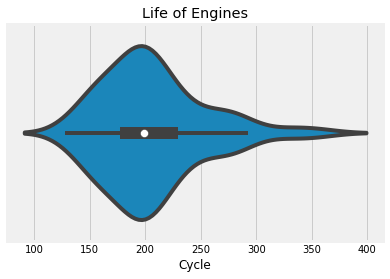

In [9]:
temp_df = df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max()
sns.violinplot(temp_df.Cycle)
plt.title("Life of Engines")

As the plot shows, average life of an Engine is around 200 cycles but some engines lived 360 cycles as well.

##### Engines having maximum life

In [10]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).head(5)

Cycle
UnitNumber       
69            362
92            341
96            336
67            313
83            293

##### Engines having minimum life

In [11]:
df_train[["UnitNumber","Cycle"]].groupby("UnitNumber").max().sort_values(by = ["Cycle"], ascending= False).tail(5)

Cycle
UnitNumber       
24            147
57            137
70            137
91            135
39            128

## Operational Setting

In our data set, each engine operates under slightly different conditions, characterized by three dimensions which change over time (e.g. altitude or external air pressure). The figure below shows the values of these operational conditions over time for the same example engine.

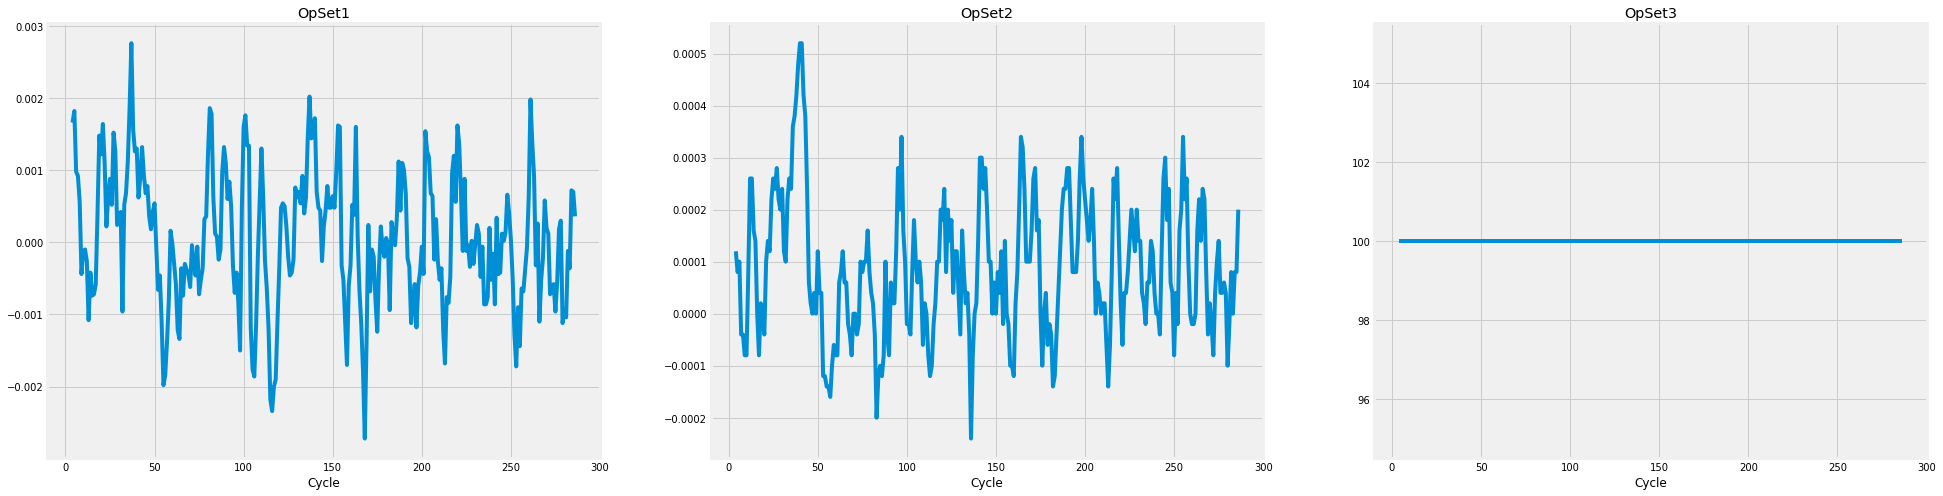

In [12]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==2').reset_index(drop = True)
    df_u1['rolling_avg'] = df_u1['OpSet'+str(i+1)].rolling(window = 5).mean()
    df_u1['rolling_avg'].plot(kind = "line", ax = ax[i])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

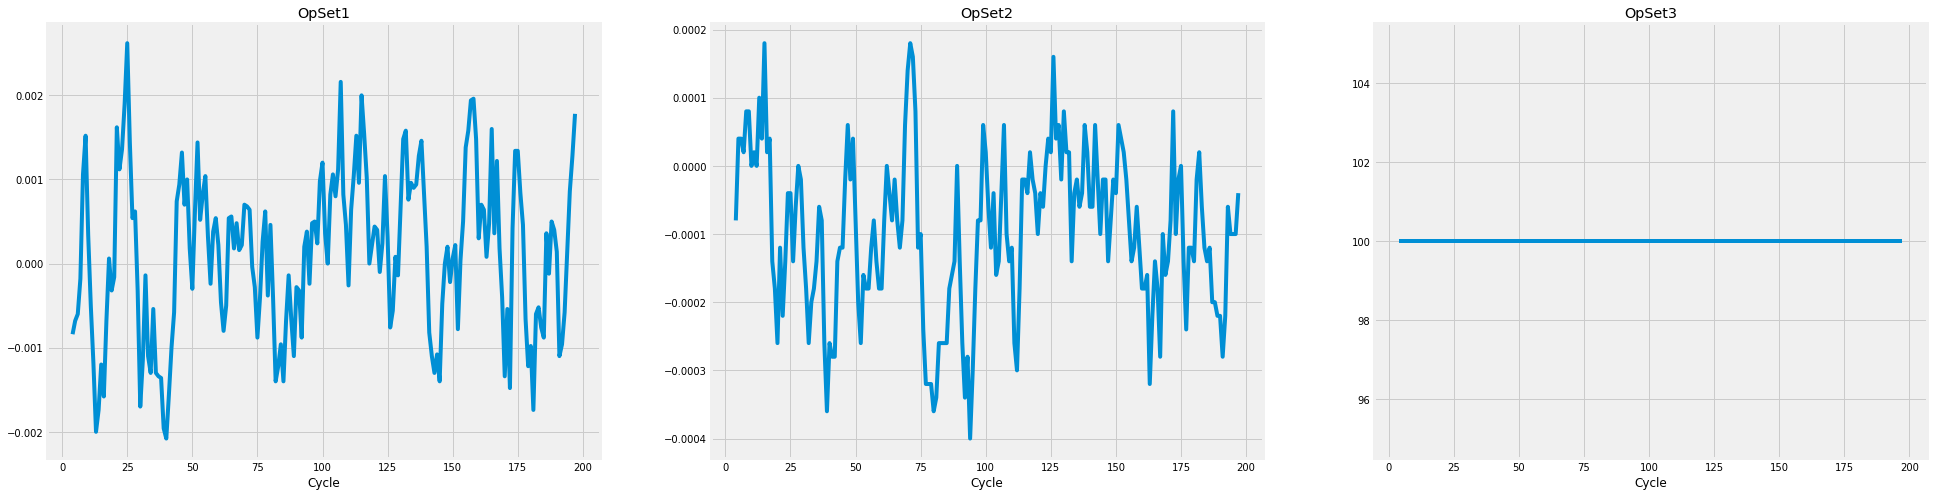

In [13]:
fig,ax=plt.subplots(1,3,figsize=(30,8),sharex='all')
for i in range(0,3):
    df_u1=df_train.query('UnitNumber==50').reset_index(drop = True)
    df_u1['rolling_avg'] = df_u1['OpSet'+str(i+1)].rolling(window = 5).mean()
    df_u1['rolling_avg'].plot(kind = "line", ax = ax[i])
    ax[i].set_title('OpSet'+str(i+1))
    ax[i].set_xlabel("Cycle")

### OpSet1

Visualizing Operating Setting 1 of units 1 to 15.

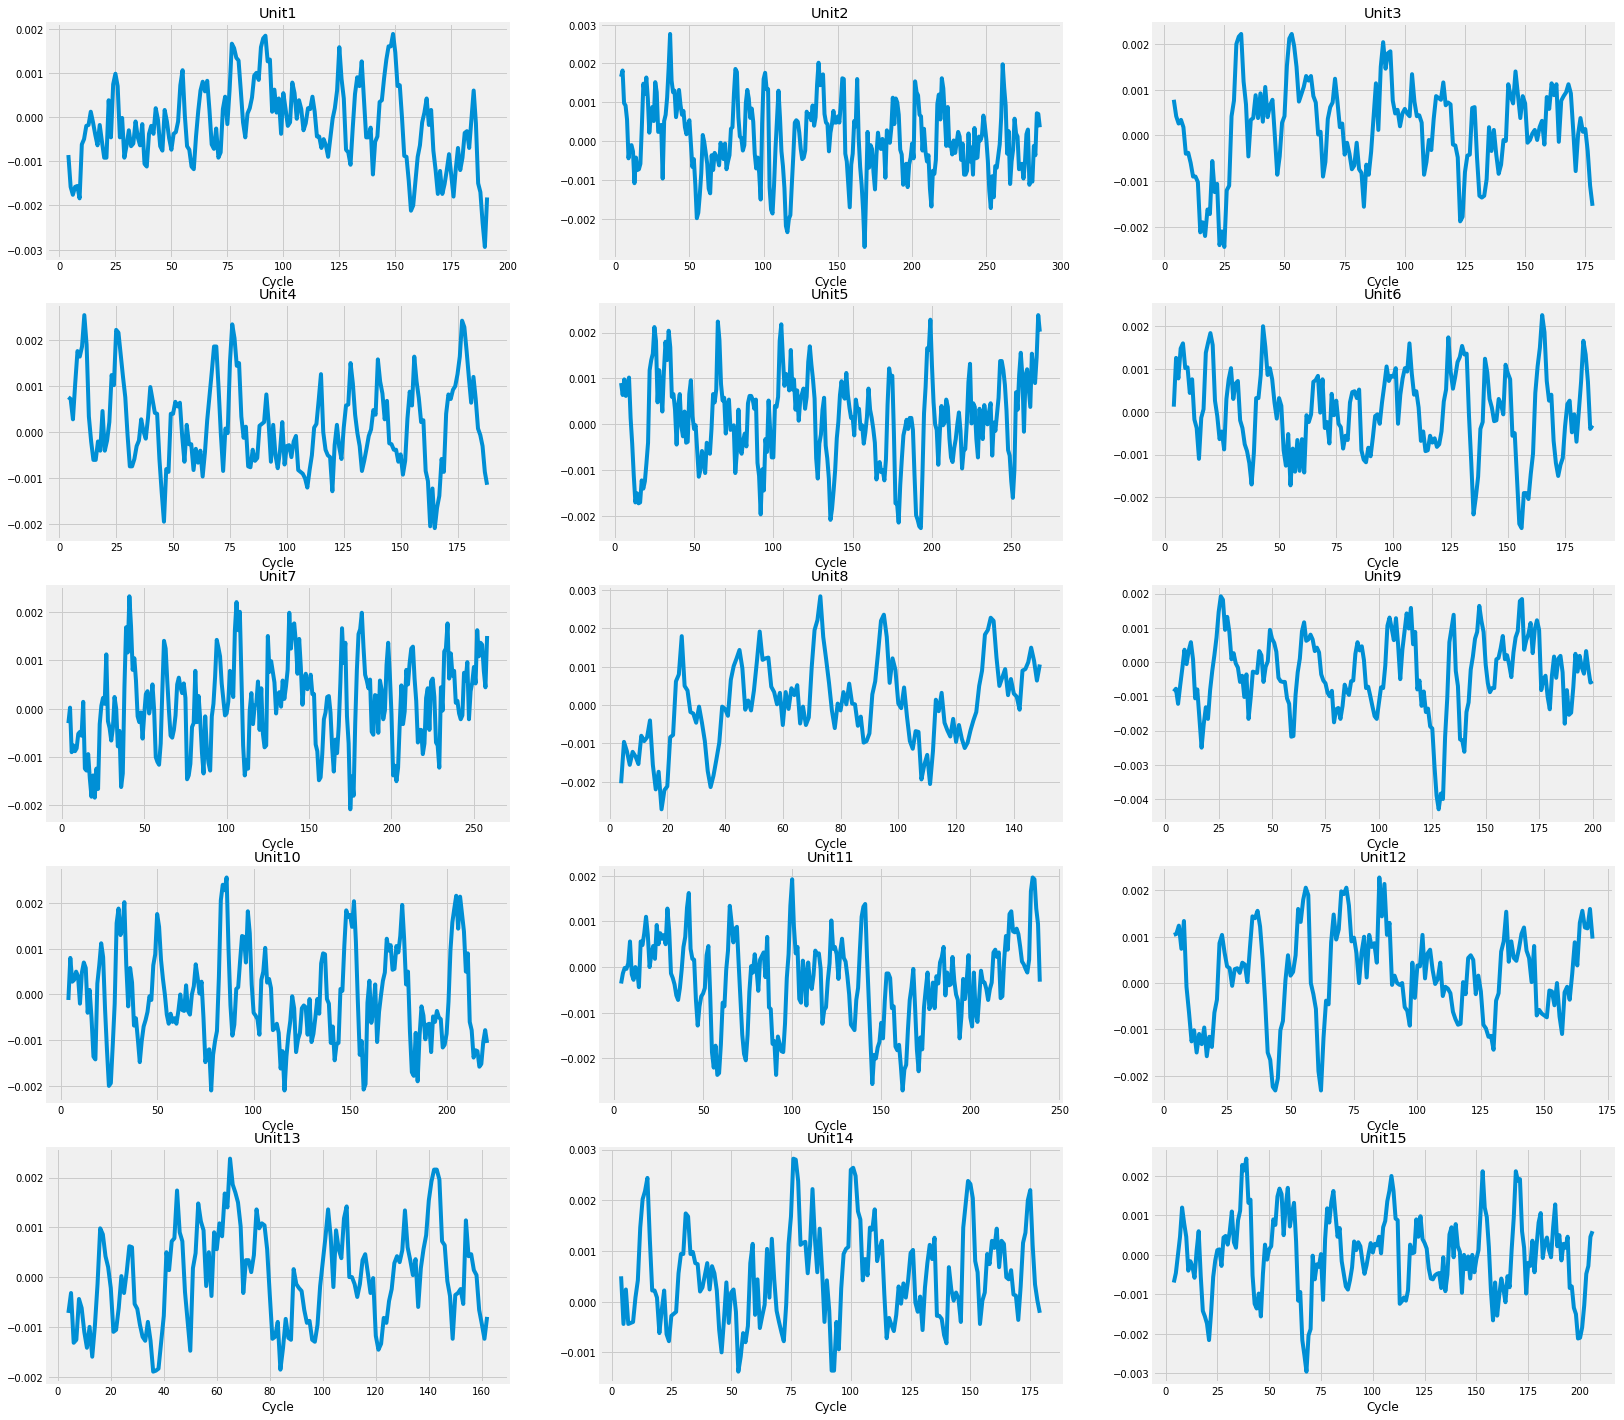

In [14]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,15):
    temp = df_train.OpSet1[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

### OpSet2

Visualizing Operating Setting 2 of units 1 to 15.

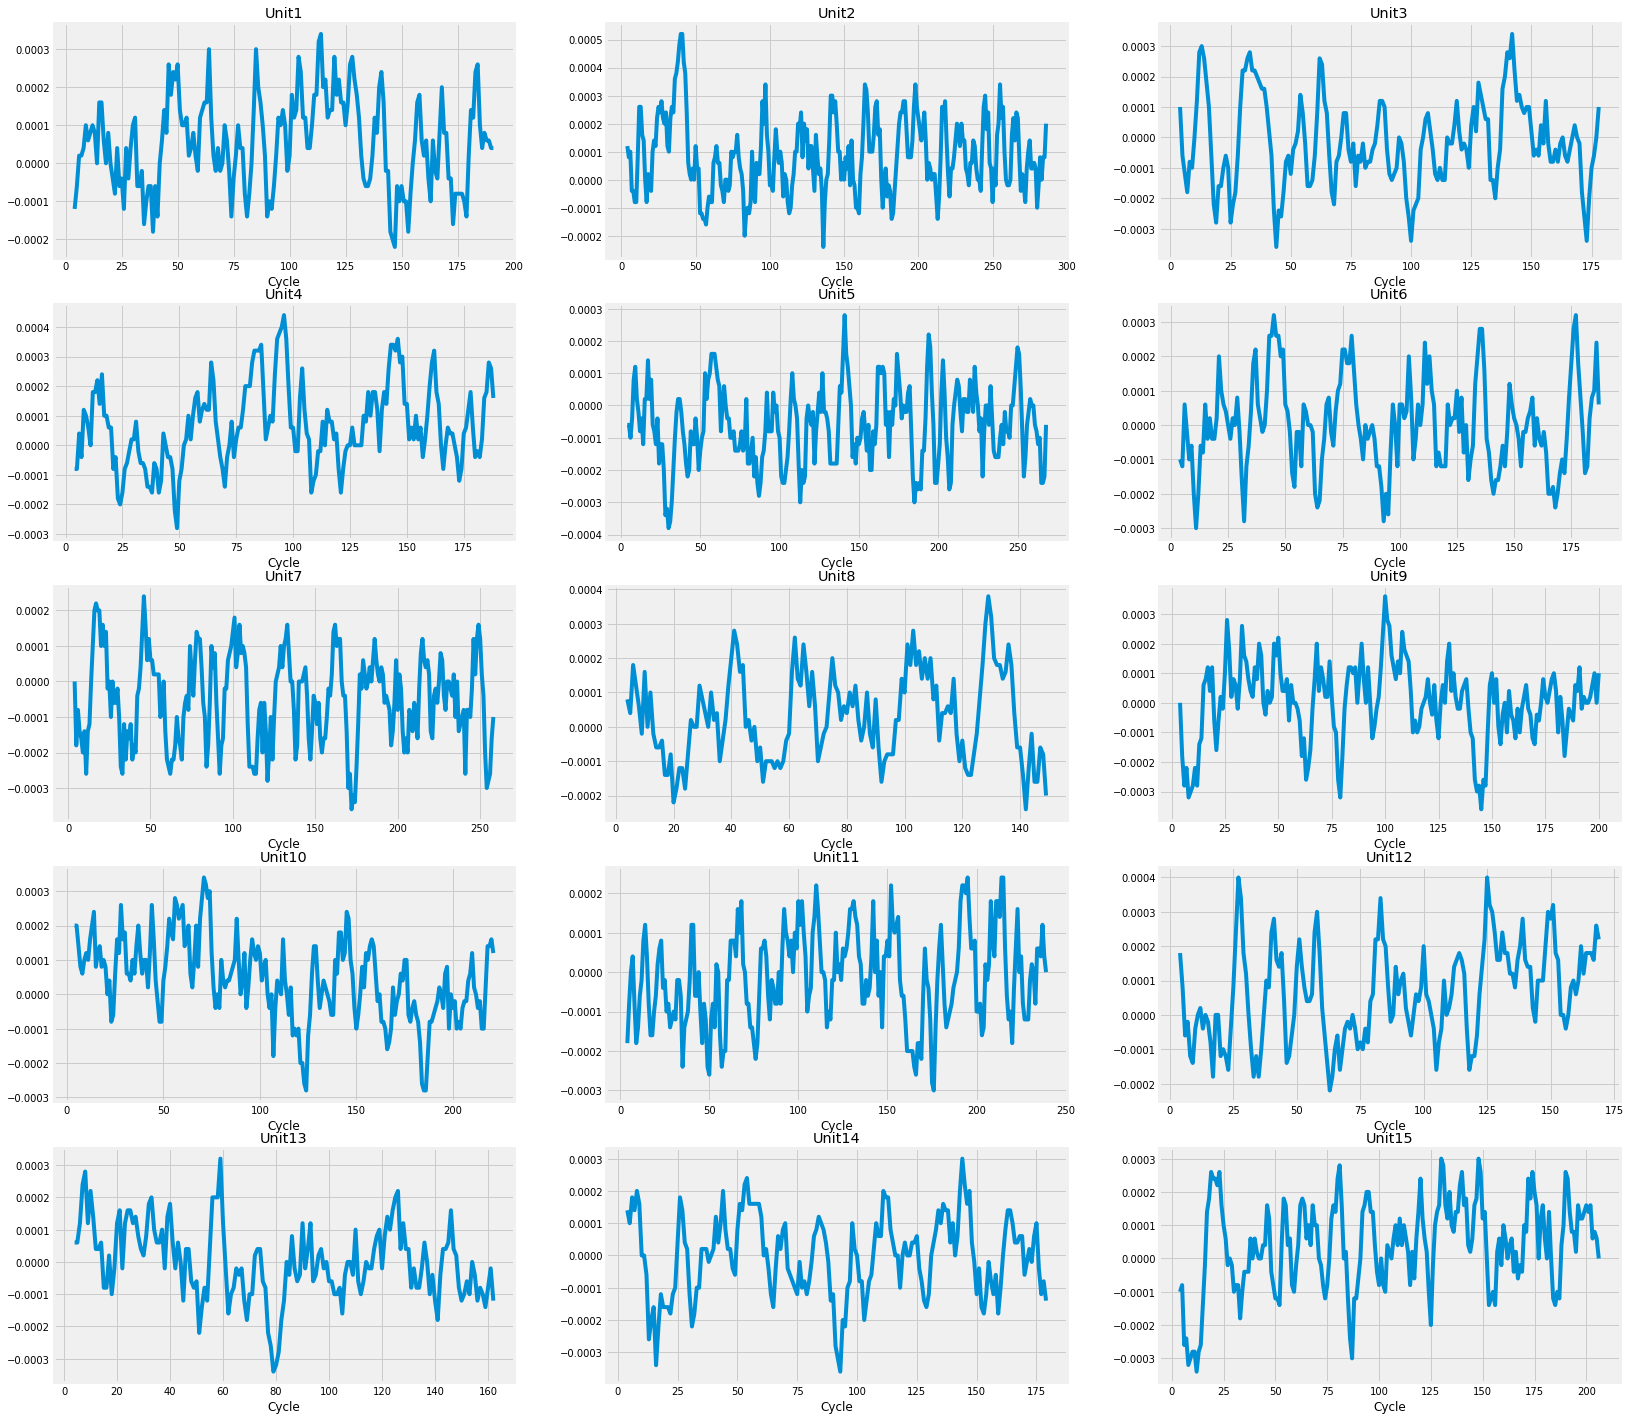

In [15]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,15):
    temp = df_train.OpSet2[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

### OpSet3

Visualizing Operating Setting 3 of units 1 to 15.

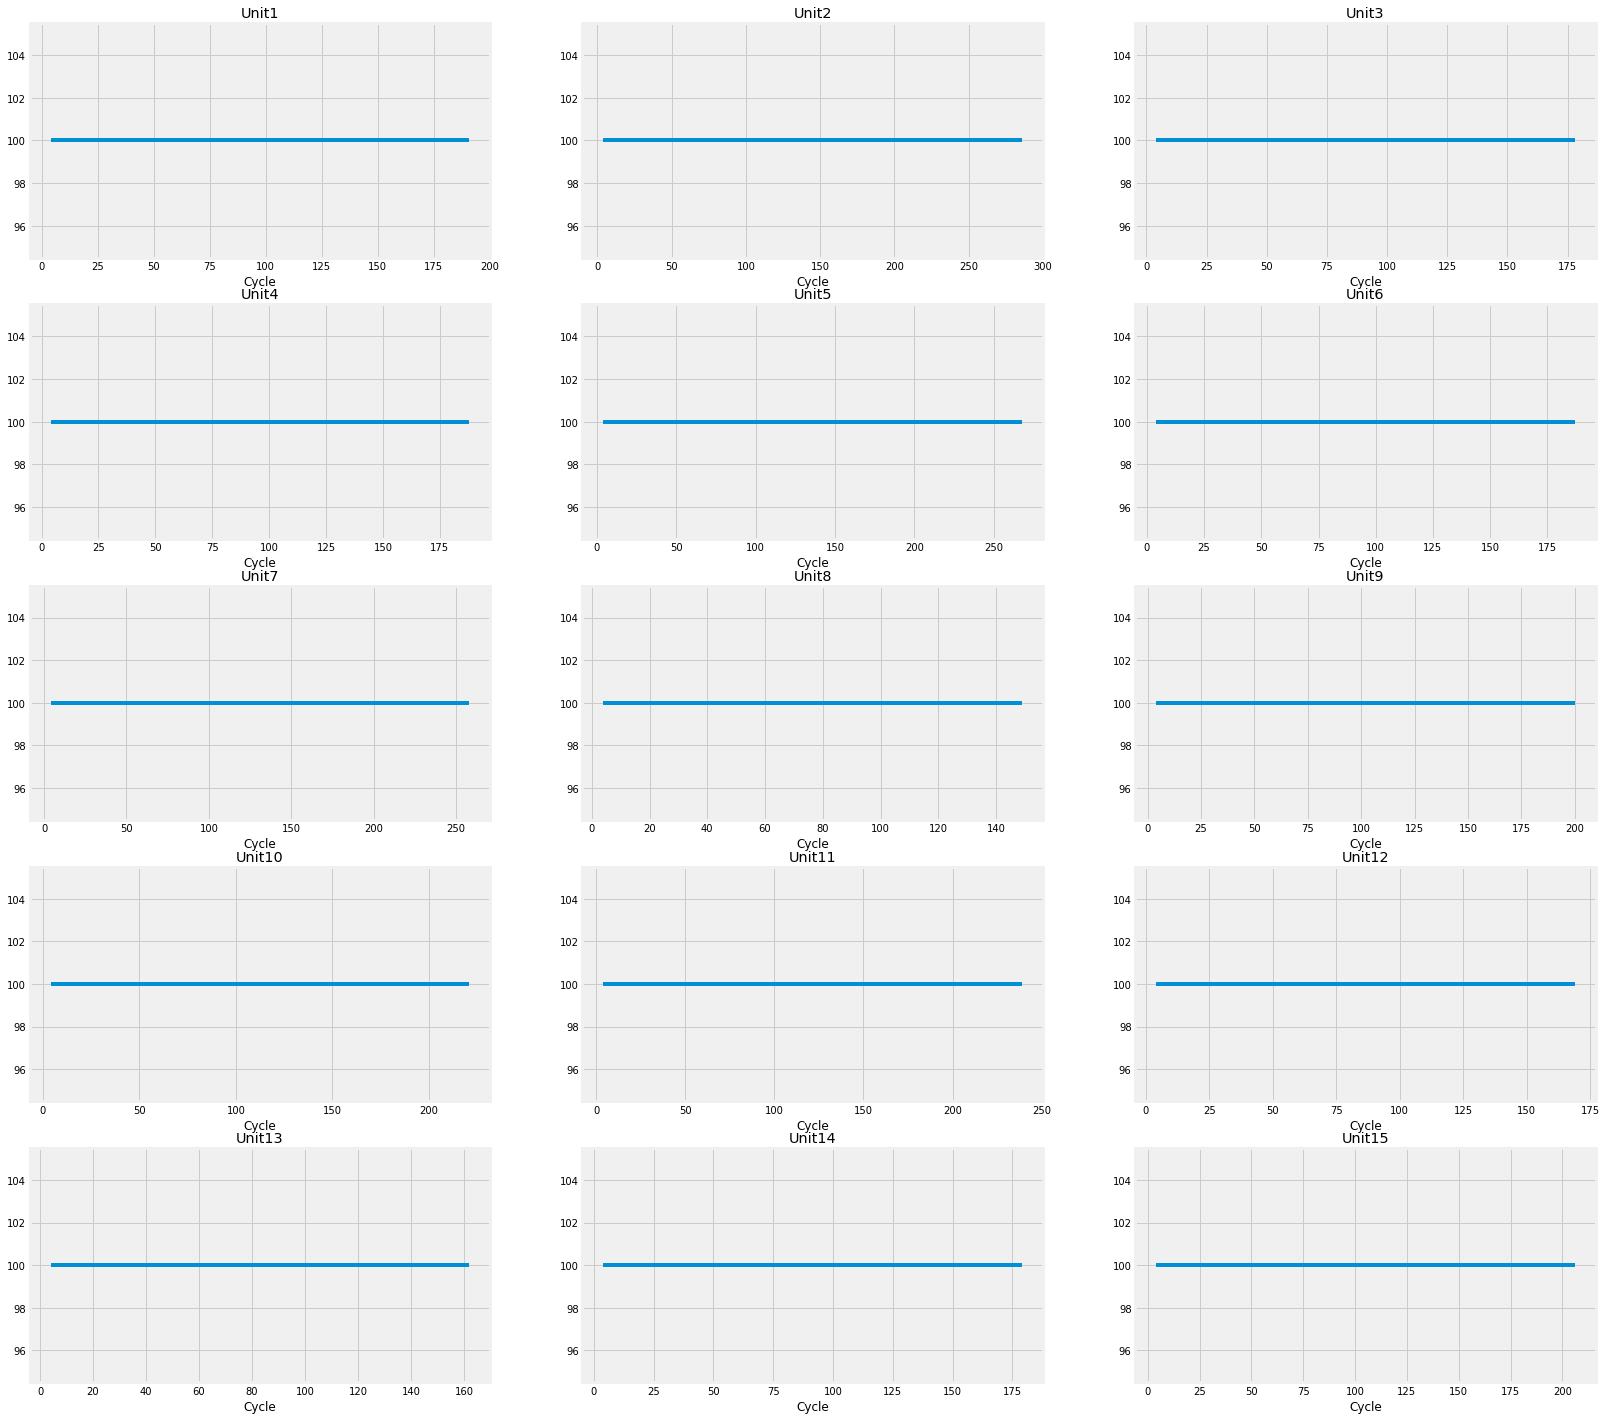

In [16]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,15):
    temp = df_train.OpSet3[df_train.UnitNumber == i+1].reset_index(drop = True).rolling(window = 5).mean()
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

In [17]:
temp_df = df_train.groupby('UnitNumber')['OpSet3'].std()
temp_df.sort_values(ascending=False).head()

UnitNumber
100    0.0
37     0.0
27     0.0
28     0.0
29     0.0
Name: OpSet3, dtype: float64

In [18]:
temp_df = df_train.groupby('UnitNumber')['OpSet3'].mean()
temp_df.sort_values(ascending=False).head()

UnitNumber
100    100.0
37     100.0
27     100.0
28     100.0
29     100.0
Name: OpSet3, dtype: float64

Operational Settings 1 and 2 do not show clear signal of failure but they might be important. Operational Setting 3 remains same throughout engine's life. Also, its value is same (i.e. 100) among all engines. Therefore, we can drop this feature.

## Sensor Measurements

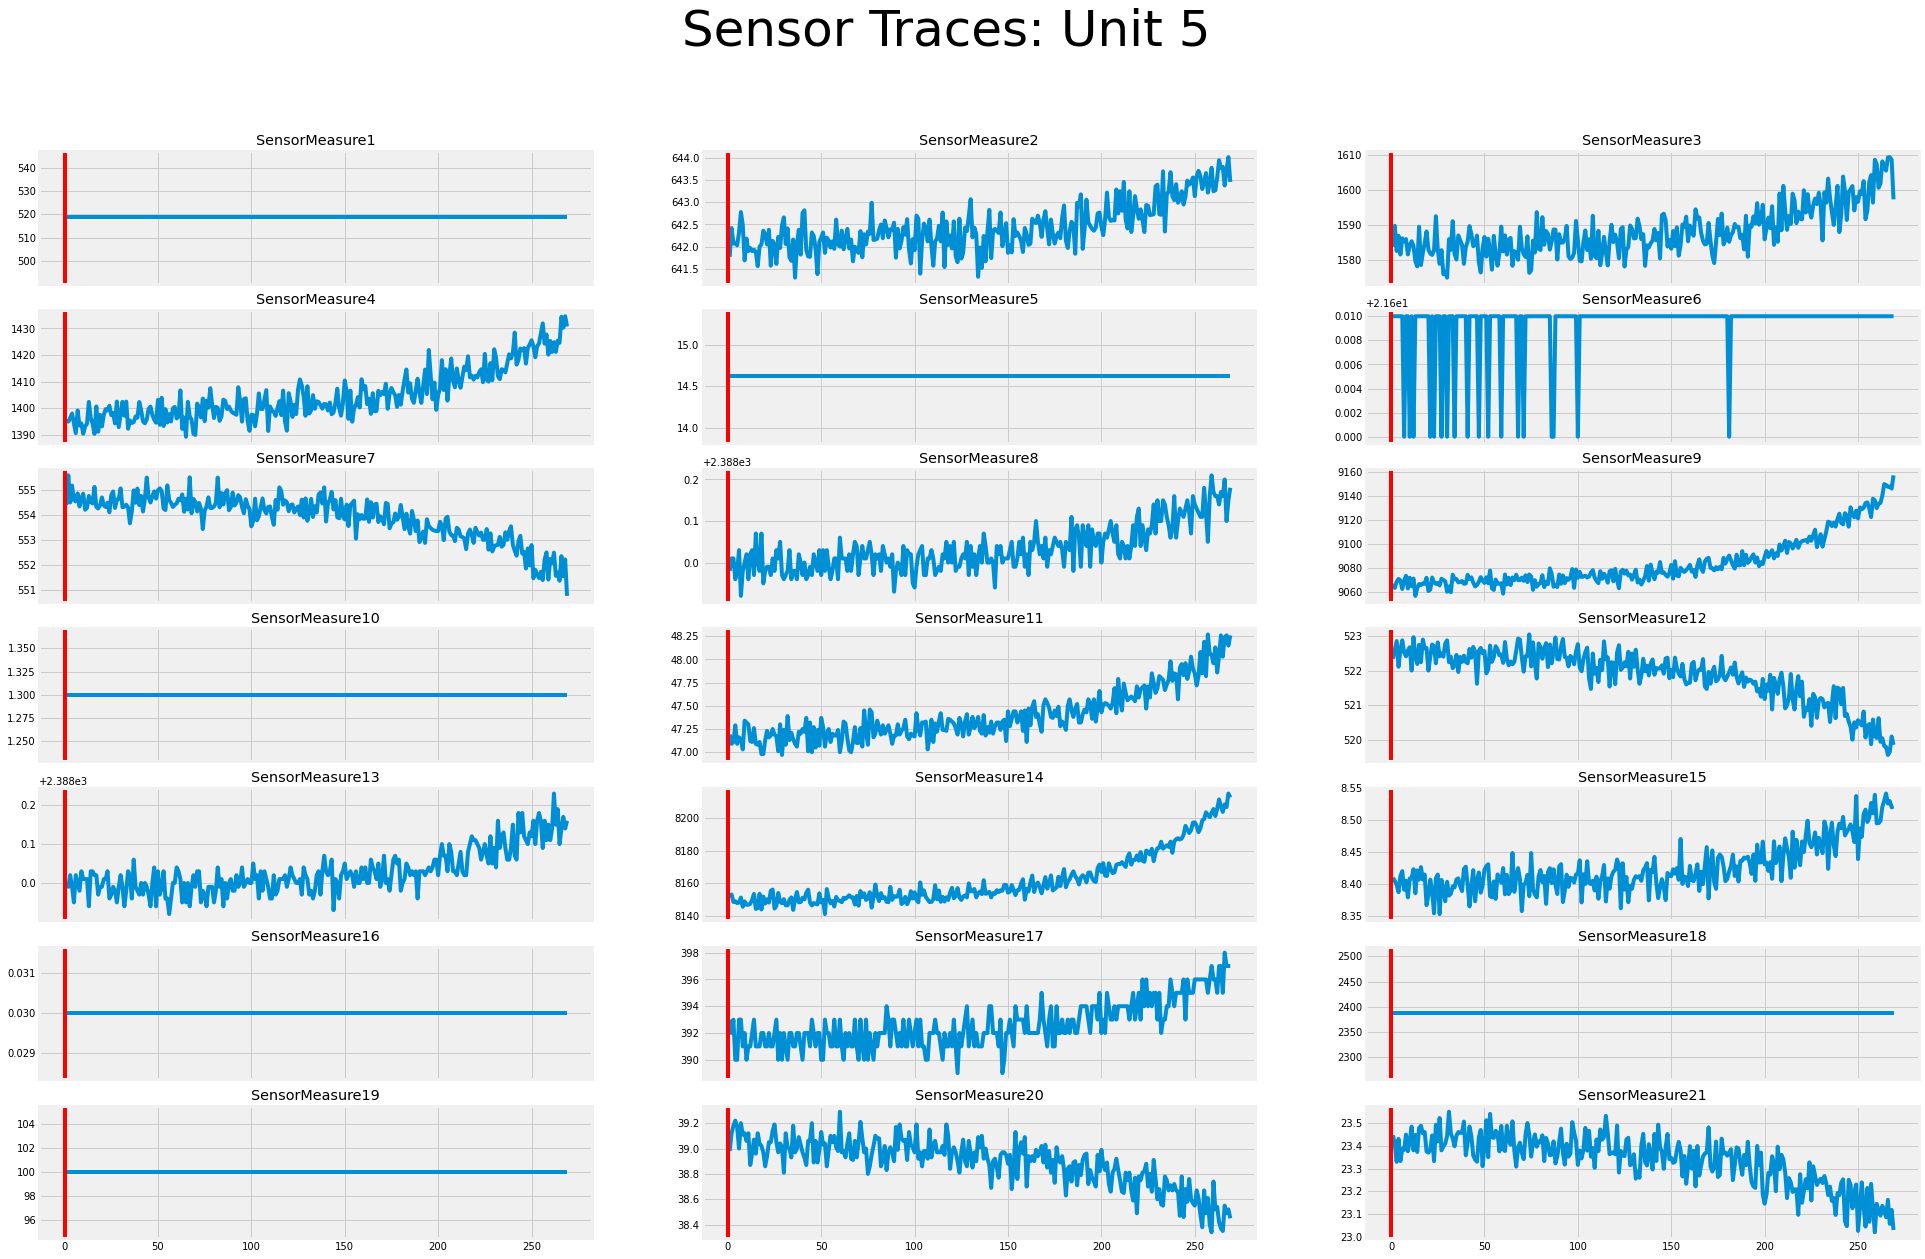

In [19]:
fig,ax=plt.subplots(7,3,figsize=(30,20),sharex=True)
df_u1=df_train.query('UnitNumber==5')
c=0
for i in range(0,7):
    for j in range(0,3):
        ax[i,j].plot(df_u1.Cycle.values, df_u1['SensorMeasure'+str(c+1)])
        ax[i,j].set_title('SensorMeasure'+str(c+1))
        ax[i,j].axvline(0,c='r')
        c+=1
plt.suptitle('Sensor Traces: Unit 5',fontsize=50)
plt.show()

Some sensors remain same throughout engine's life. Checking their values across different engines.

In [20]:
temp_df = df_train.groupby('UnitNumber').std()
temp_df.head()

Cycle    OpSet1  ...  SensorMeasure21        RUL
UnitNumber                       ...                            
1           55.569776  0.001953  ...         0.105101  55.569776
2           82.993976  0.002320  ...         0.114796  82.993976
3           51.816986  0.002145  ...         0.104734  51.816986
4           54.703748  0.002033  ...         0.093804  54.703748
5           77.797815  0.002119  ...         0.112705  77.797815

[5 rows x 26 columns]

In [21]:
temp_df.sum(axis = 0) == 0

Cycle              False
OpSet1             False
OpSet2             False
OpSet3              True
SensorMeasure1      True
SensorMeasure2     False
SensorMeasure3     False
SensorMeasure4     False
SensorMeasure5      True
SensorMeasure6     False
SensorMeasure7     False
SensorMeasure8     False
SensorMeasure9     False
SensorMeasure10     True
SensorMeasure11    False
SensorMeasure12    False
SensorMeasure13    False
SensorMeasure14    False
SensorMeasure15    False
SensorMeasure16     True
SensorMeasure17    False
SensorMeasure18     True
SensorMeasure19     True
SensorMeasure20    False
SensorMeasure21    False
RUL                False
dtype: bool

#### Sensor Measure 1

In [22]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure1'].mean()
temp_df.head()

UnitNumber
1    518.67
2    518.67
3    518.67
4    518.67
5    518.67
Name: SensorMeasure1, dtype: float64

In [23]:
temp_df.min(), temp_df.max()

(518.6699999999985, 518.6700000000028)

#### Sensor Measure 5

In [24]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure5'].mean()
temp_df.head()

UnitNumber
1    14.62
2    14.62
3    14.62
4    14.62
5    14.62
Name: SensorMeasure5, dtype: float64

In [25]:
temp_df.min(), temp_df.max()

(14.619999999999914, 14.619999999999953)

#### Sensor Measure 10

In [26]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure10'].mean()
temp_df.head()

UnitNumber
1    1.3
2    1.3
3    1.3
4    1.3
5    1.3
Name: SensorMeasure10, dtype: float64

In [27]:
temp_df.min(), temp_df.max()

(1.3000000000000012, 1.3000000000000078)

#### Sensor Measure 16

In [28]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure16'].mean()
temp_df.head()

UnitNumber
1    0.03
2    0.03
3    0.03
4    0.03
5    0.03
Name: SensorMeasure16, dtype: float64

In [29]:
temp_df.min(), temp_df.max()

(0.02999999999999989, 0.03000000000000008)

#### Sensor Measure 18

In [30]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure18'].mean()
temp_df.head()

UnitNumber
1    2388
2    2388
3    2388
4    2388
5    2388
Name: SensorMeasure18, dtype: int64

In [31]:
temp_df.min(), temp_df.max()

(2388, 2388)

#### Sensor Measure 19

In [32]:
temp_df = df_train.groupby('UnitNumber')['SensorMeasure19'].mean()
temp_df.head()

UnitNumber
1    100.0
2    100.0
3    100.0
4    100.0
5    100.0
Name: SensorMeasure19, dtype: float64

In [33]:
temp_df.min(), temp_df.max()

(100.0, 100.0)

As we can see SensorMeasure1, SensorMeasure5, SensorMeasure10, SensorMeasure16, SensorMeasure18 and SensorMeasure19 do not add value and we can remove them from analysis to reduce the complexity of our model. 

#### Sensor Measure 6

Visualizing Sensor Measure 6 of units 1 to 15.

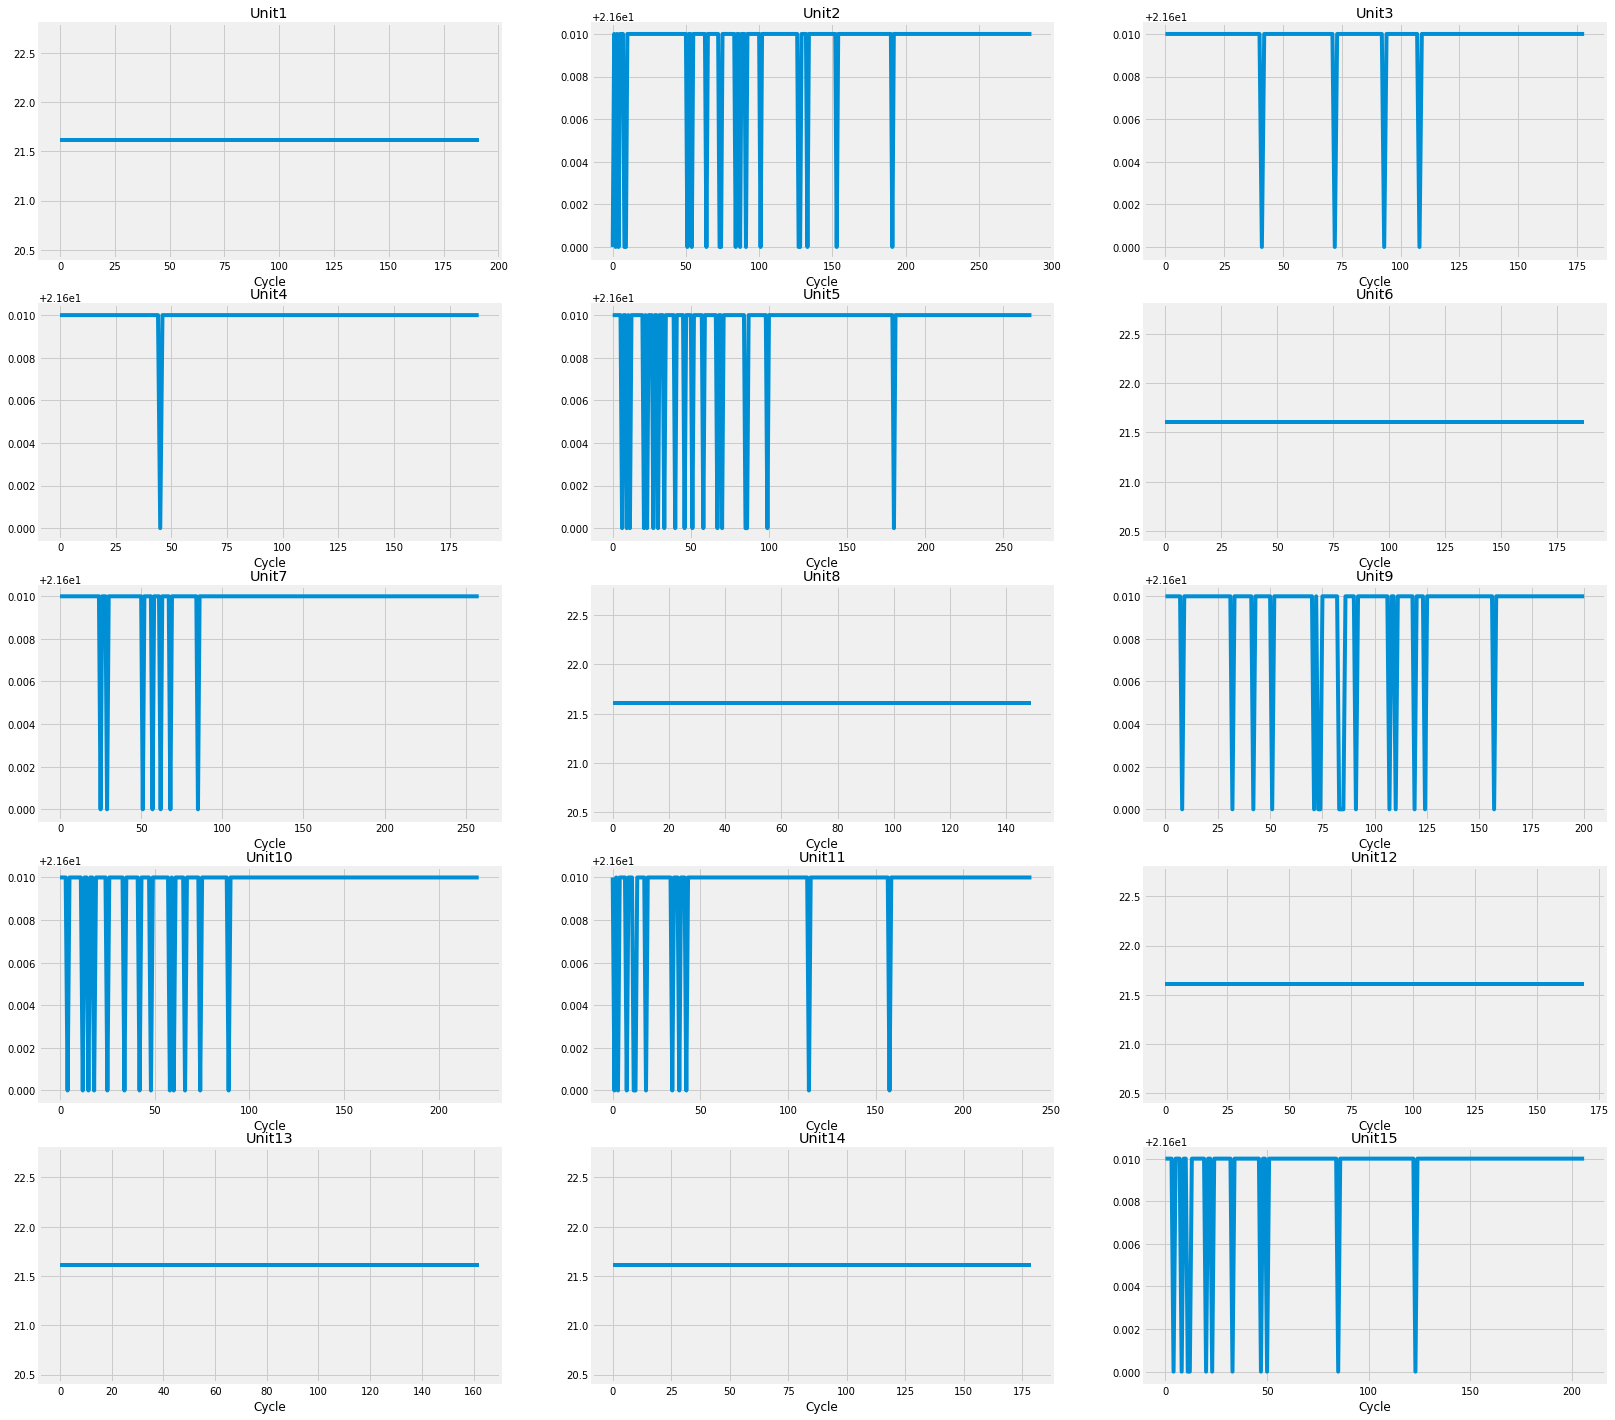

In [34]:
fig, axes = plt.subplots(nrows = 5, ncols = 3, figsize = (25,25))

ax = axes.ravel()

for i in range(0,15):
    temp = df_train.SensorMeasure6[df_train.UnitNumber == i+1].reset_index(drop = True)
    temp.plot(kind = "line", ax = ax[i])
    ax[i].set_title('Unit'+str(i+1))
    ax[i].set_xlabel("Cycle")

In [35]:
df_train.SensorMeasure6.value_counts()

21.61    20225
21.60      406
Name: SensorMeasure6, dtype: int64

Sensor Measure 6 remains almost constant as well with some minor fluctuations and we can remove it as well.

In [36]:
# necessary features for analysis
not_required_feats = ["SensorMeasure1", "SensorMeasure5", "SensorMeasure6", "SensorMeasure10", 
                      "SensorMeasure16", "SensorMeasure18", "SensorMeasure19"]
feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure14',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

### Correlation Analysis

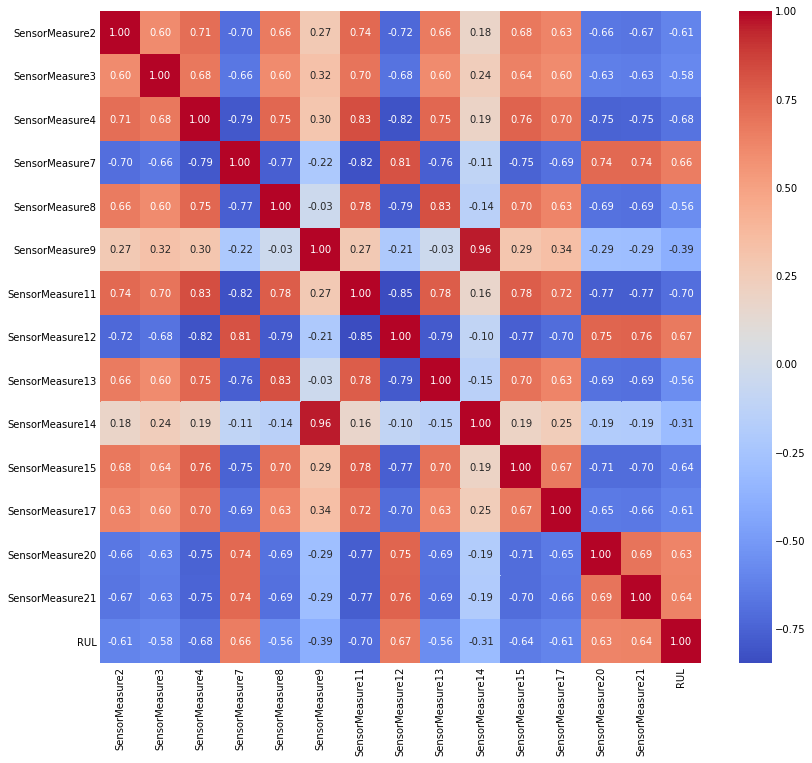

In [37]:
corr = df_train[feats + ["RUL"]].corr()

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
ax = sns.heatmap(corr, annot=True, cmap = "coolwarm", fmt=".2f")

As we can see, Sensor 14 and Sensor 9 are higly correlated.

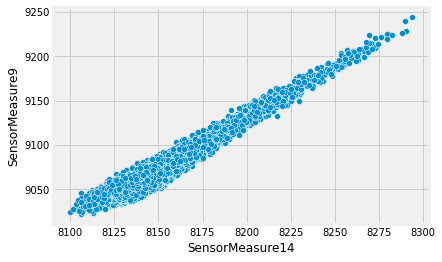

In [38]:
sns.scatterplot(x = df_train.SensorMeasure14, y = df_train.SensorMeasure9)

Since both of these sensors are highly correlated with eachother and Sensor Measure 9 is higly correlated with RUL, we drop Sensor Measure 14.

In [39]:
feats = [i for i in feats if "SensorMeasure14" not in i]
feats

['SensorMeasure2',
 'SensorMeasure3',
 'SensorMeasure4',
 'SensorMeasure7',
 'SensorMeasure8',
 'SensorMeasure9',
 'SensorMeasure11',
 'SensorMeasure12',
 'SensorMeasure13',
 'SensorMeasure15',
 'SensorMeasure17',
 'SensorMeasure20',
 'SensorMeasure21']

### Visualizing sensor values before failure

In [40]:
group_df = df_train[(df_train.UnitNumber <= 10) & (df_train.RUL <= 50)].groupby('UnitNumber', as_index = False).\
    apply(lambda x: x.reset_index(drop = True)).reset_index()
group_df.head()

level_0  level_1  UnitNumber  ...  SensorMeasure20  SensorMeasure21  RUL
0        0        0           1  ...            38.71          23.2816   50
1        0        1           1  ...            38.79          23.2305   49
2        0        2           1  ...            38.75          23.2249   48
3        0        3           1  ...            38.67          23.1490   47
4        0        4           1  ...            38.69          23.3233   46

[5 rows x 29 columns]

In [41]:
group_df.tail()

level_0  level_1  UnitNumber  ...  SensorMeasure20  SensorMeasure21  RUL
505        9       46          10  ...            38.47          23.1209    4
506        9       47          10  ...            38.48          23.2340    3
507        9       48          10  ...            38.53          23.2187    2
508        9       49          10  ...            38.22          23.1596    1
509        9       50          10  ...            38.51          23.1434    0

[5 rows x 29 columns]

In [42]:
group_df = group_df.drop('level_0',axis = 1).set_index('level_1')
group_df.head()

UnitNumber  Cycle  OpSet1  ...  SensorMeasure20  SensorMeasure21  RUL
level_1                             ...                                       
0                 1    142  0.0026  ...            38.71          23.2816   50
1                 1    143 -0.0005  ...            38.79          23.2305   49
2                 1    144  0.0025  ...            38.75          23.2249   48
3                 1    145 -0.0004  ...            38.67          23.1490   47
4                 1    146  0.0002  ...            38.69          23.3233   46

[5 rows x 27 columns]

Visualizing different sensor values of last 50 cycles before failure 

In [43]:
len(feats)

13

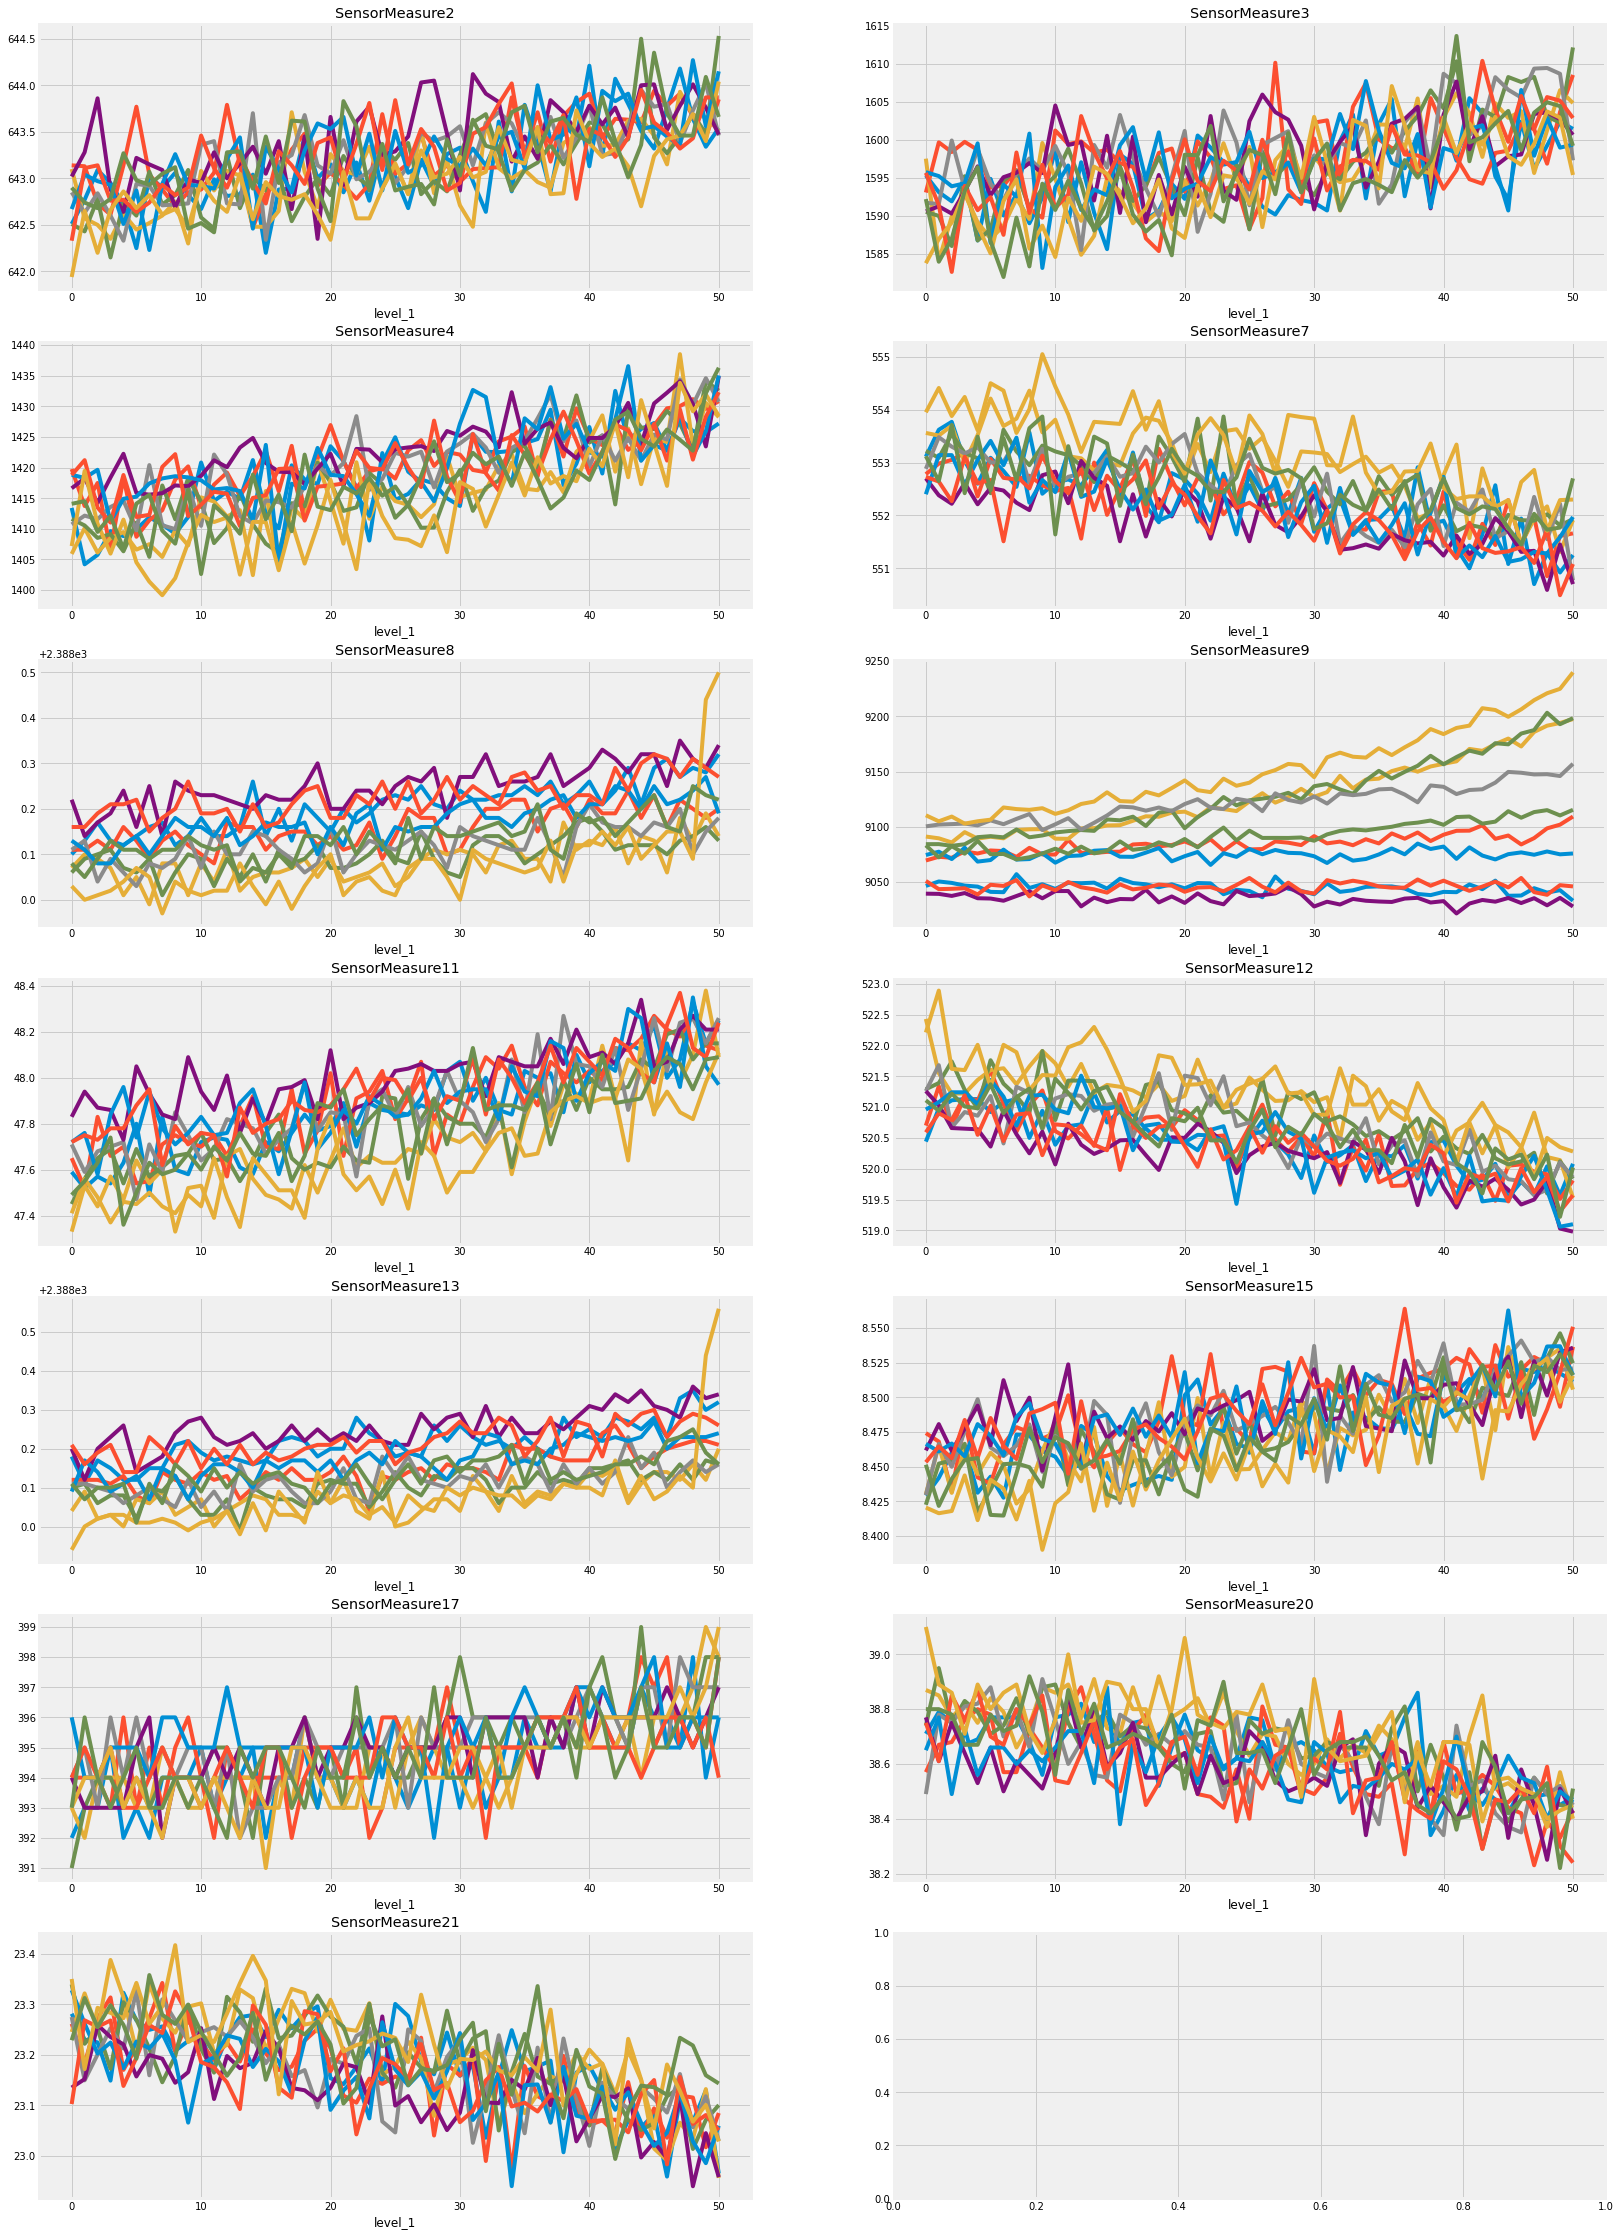

In [44]:
fig, ax = plt.subplots(figsize = (25,40), ncols = 2, nrows = 7)

ax = ax.ravel()
for i, feat in enumerate(feats):
    group_df.groupby('UnitNumber')[feat].plot(kind = "line", ax = ax[i])
    ax[i].set_title(feat)

We see a strong signal in last 50 days before an engine's failure which can be quantified using various techniques. Also, Sensor Measure 9 seems having different values for different engines which might not be helpful for our analysis. But, let's not drop it for now.

### Final scripts to preprocess data.

In [45]:
def prepare_data(drop_cols = True):
    dependent_var = ['RUL']
    index_columns_names =  ["UnitNumber","Cycle"]
    operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]
    sensor_measure_columns_names =["SensorMeasure"+str(i) for i in range(1,22)]
    input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

    cols_to_drop = ['OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure6', 'SensorMeasure10', 'SensorMeasure14',
     'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19']

    df_train = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

    rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
    rul.columns = ['UnitNumber', 'max']
    df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
    df_train['RUL'] = df_train['max'] - df_train['Cycle']
    df_train.drop('max', axis=1, inplace=True)

    df_test = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/test_FD001.txt', delim_whitespace=True, names=input_file_column_names)
    
    if(drop_cols == True):
        df_train = df_train.drop(cols_to_drop, axis = 1)
        df_test = df_test.drop(cols_to_drop, axis = 1)

    y_true = pd.read_csv('https://raw.githubusercontent.com/ericlrf/rul/main/CMAPSSData/RUL_FD001.txt', delim_whitespace=True,names=["RUL"])
    y_true["UnitNumber"] = y_true.index
    
    return df_train, df_test, y_true

In [46]:
train, test, ground_truth = prepare_data()

In [48]:
train

UnitNumber  Cycle  OpSet1  ...  SensorMeasure20  SensorMeasure21  RUL
0               1      1 -0.0007  ...            39.06          23.4190  191
1               1      2  0.0019  ...            39.00          23.4236  190
2               1      3 -0.0043  ...            38.95          23.3442  189
3               1      4  0.0007  ...            38.88          23.3739  188
4               1      5 -0.0019  ...            38.90          23.4044  187
...           ...    ...     ...  ...              ...              ...  ...
20626         100    196 -0.0004  ...            38.49          22.9735    4
20627         100    197 -0.0016  ...            38.30          23.1594    3
20628         100    198  0.0004  ...            38.44          22.9333    2
20629         100    199 -0.0011  ...            38.29          23.0640    1
20630         100    200 -0.0032  ...            38.37          23.0522    0

[20631 rows x 18 columns]

In [49]:
test

UnitNumber  Cycle  ...  SensorMeasure20  SensorMeasure21
0               1      1  ...            38.86          23.3735
1               1      2  ...            39.02          23.3916
2               1      3  ...            39.08          23.4166
3               1      4  ...            39.00          23.3737
4               1      5  ...            38.99          23.4130
...           ...    ...  ...              ...              ...
13091         100    194  ...            38.65          23.1974
13092         100    195  ...            38.57          23.2771
13093         100    196  ...            38.62          23.2051
13094         100    197  ...            38.66          23.2699
13095         100    198  ...            38.70          23.1855

[13096 rows x 17 columns]

In [47]:
ground_truth

RUL  UnitNumber
0   112           0
1    98           1
2    69           2
3    82           3
4    91           4
..  ...         ...
95  137          95
96   82          96
97   59          97
98  117          98
99   20          99

[100 rows x 2 columns]